# Performance Stability and Runtime Analysis
This notebook evaluates the robustness of the XGBoost regressor on the rogue wave dataset by repeating the best-performing model across stratified folds and analysing the resulting error metrics and target distributions.

**Imports**

In [ ]:
import time
import pandas as pd

from xgboost import XGBRegressor  
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

seed = 42

**Data Loading**

In [2]:
# Data file
file_data = '../data/abin_matrix_full_encoded.csv'

# Thresholds
threshold_upper_limit = 2.7
threshold_non_rogue_wave = 1.5
threshold_rogue_wave = 2.0

# Features and target
target = 'AI_10min'
target_cat = 'AI_10min_cat'
features = ['H_s', 'lambda_40', 'lambda_30', 'L_deep', 's', 'mu', 'kh', 'T_p','nu', 'Q_p', 'BFI', 'r', 'v_wind', 'v_gust', 'T_air', 'p', 'Delta_p_1h']

In [3]:
data_rogue_waves = pd.read_csv(file_data)

data_rogue_waves = data_rogue_waves.loc[data_rogue_waves.AI_10min < threshold_upper_limit]
data_rogue_waves = data_rogue_waves.loc[:,[target]+features]

data_rogue_waves_class = data_rogue_waves.copy()
data_rogue_waves_class[target_cat] = data_rogue_waves_class[target].apply(lambda x: 0 if x < threshold_non_rogue_wave else (1 if x < threshold_rogue_wave else 2))
data_rogue_waves_class[target_cat] = data_rogue_waves_class[target_cat].astype(int)

X = data_rogue_waves_class.drop(columns=["AI_10min", "AI_10min_cat"])
y = data_rogue_waves_class["AI_10min"]
y_cat = data_rogue_waves_class["AI_10min_cat"]

**Stability and Runtime Analysis**

In [4]:
hyperparameters_xgb = {"colsample_bytree": 0.8, "gamma": 0, "learning_rate": 0.1, "max_depth": 20, "min_child_weight": 1, "n_estimators": 100, "reg_alpha": 0, "reg_lambda": 1, "subsample": 0.5}

In [5]:
model_performance_test = []
model_runtime = []
targets_train = {}
targets_test = {}

In [6]:
skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [7]:
for i, (train_index, test_index) in enumerate(skf.split(X, y_cat)):
    fold = i+1

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

    targets_train[f"Distribution for train set target of fold {fold}"] = y_train
    targets_test[f"Distribution for test set target of fold {fold}"] = y_test

    start = time.time()
    model = XGBRegressor(random_state=seed, **hyperparameters_xgb)

    model.fit(X_train, y_train)
    end = time.time()
    model_runtime.append(end - start)

    y_pred = model.predict(X_test)
    y_true = y_test
    model_performance_test.append(r2_score(y_true, y_pred))
    time.sleep(10)

targets_train = pd.DataFrame(targets_train)
targets_test = pd.DataFrame(targets_test)

**Plot Results**

In [8]:
print(f"XGBoost Regression Results: {model_performance_test}")
print(f"Average R2 Score on Test Sets: {sum(model_performance_test)/len(model_performance_test)}")
print(f"Average Model Runtime per Fold: {sum(model_runtime)/len(model_runtime)} seconds")

XGBoost Regression Results: [0.9636582388617217, 0.9632735919527383, 0.9625224735480925, 0.9631305826650034, 0.964795447656241]
Average R2 Score on Test Sets: 0.9634760669367595
Average Model Runtime per Fold: 54.95873808860779 seconds


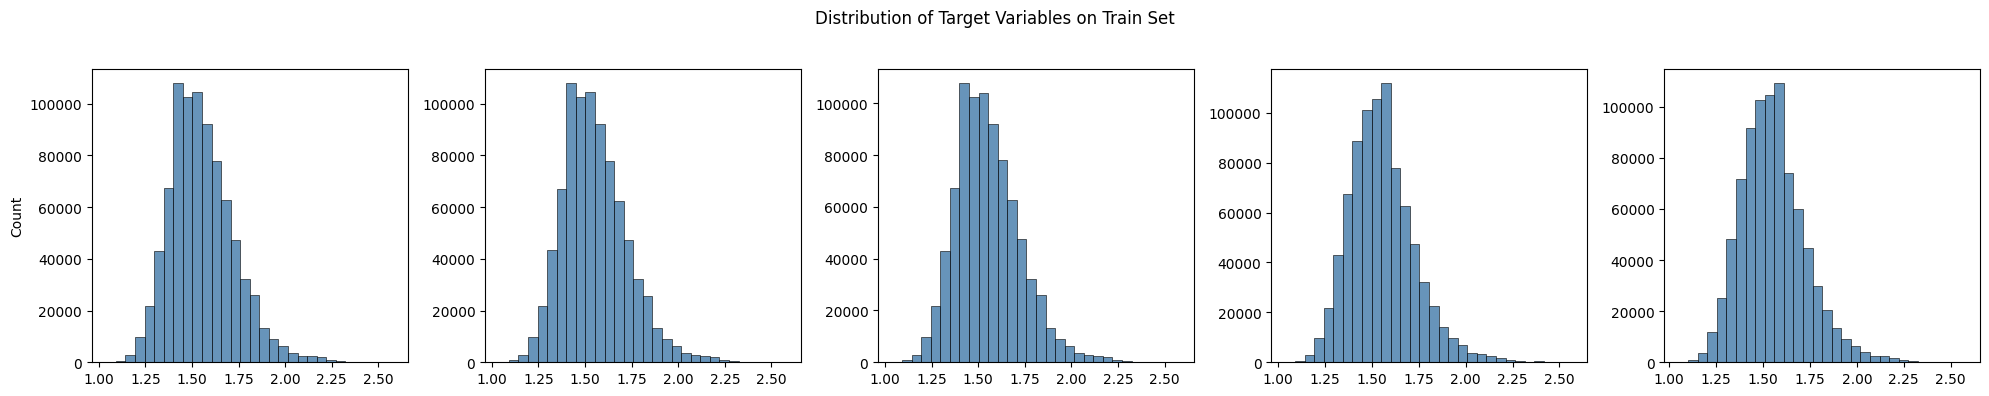

In [9]:
plt.figure(figsize=(20,4))
plt.subplots_adjust(top=0.95, hspace=0.8, wspace=0.8)
plt.suptitle("Distribution of Target Variables on Train Set")

for n, feature in enumerate(targets_train.columns):
    # add a new subplot iteratively
    ax = plt.subplot(1, 5, n + 1)
    sns.histplot(
        data=targets_train,
        x=feature,
        bins=30,
        ax=ax,
        color="#3470a3",
    )
    ax.set_xlabel("")  
    if n > 0:
        ax.set_ylabel("")

plt.tight_layout(rect=[0, 0, 1, 0.95])

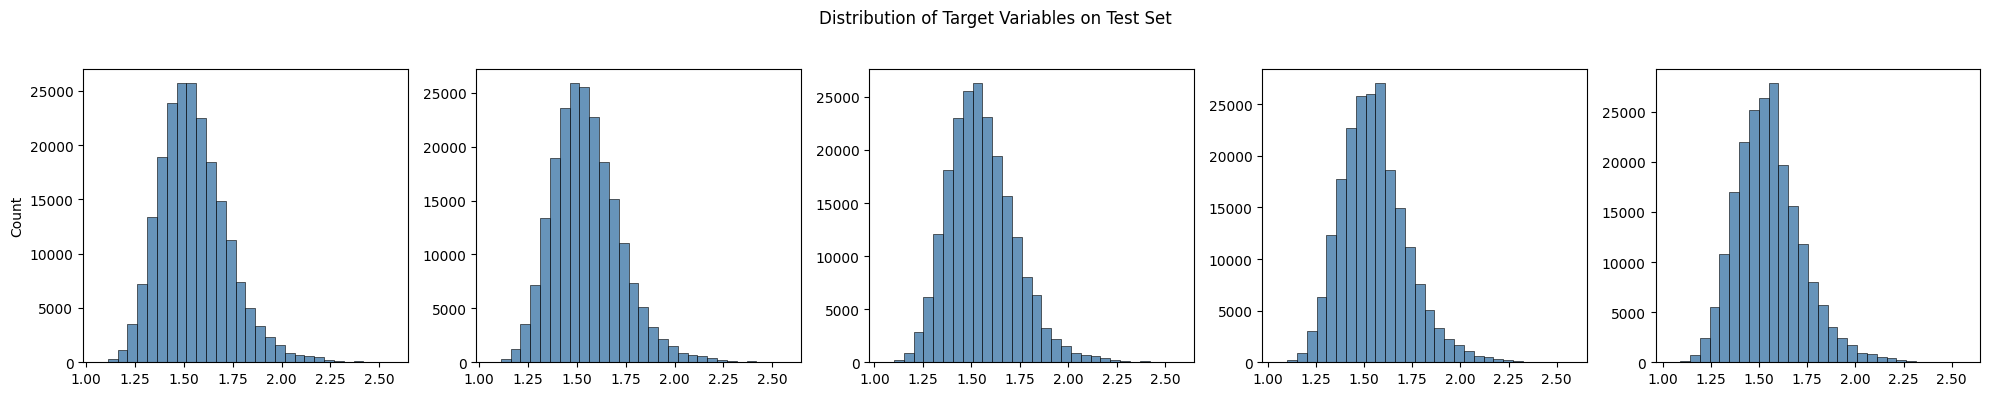

In [10]:
plt.figure(figsize=(20,4))
plt.subplots_adjust(top=0.95, hspace=0.8, wspace=0.8)
plt.suptitle("Distribution of Target Variables on Test Set")

for n, feature in enumerate(targets_test.columns):
    # add a new subplot iteratively
    ax = plt.subplot(1, 5, n + 1)
    sns.histplot(
        data=targets_test,
        x=feature,
        bins=30,
        ax=ax,
        color="#3470a3",
    )
    ax.set_xlabel("")  
    if n > 0:
        ax.set_ylabel("")

plt.tight_layout(rect=[0, 0, 1, 0.95])